# Section 6

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

In [2]:
import irbasis3

## Generate IR basis by singular value expansion

In [3]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-10)

## Singular values

In [4]:
basis.s

array([1.45387261e+00, 1.24137141e+00, 7.98387159e-01, 5.34115485e-01,
       3.19202855e-01, 1.88195405e-01, 1.06269952e-01, 5.84664007e-02,
       3.12626140e-02, 1.62959998e-02, 8.28608690e-03, 4.11383766e-03,
       1.99543191e-03, 9.46115126e-04, 4.38678206e-04, 1.98971153e-04,
       8.83076718e-05, 3.83596425e-05, 1.63120097e-05, 6.79164595e-06,
       2.76915058e-06, 1.10582146e-06, 4.32562293e-07, 1.65764896e-07,
       6.22400190e-08, 2.28998146e-08, 8.25716208e-09, 2.91821977e-09,
       1.01098806e-09, 3.43374895e-10])

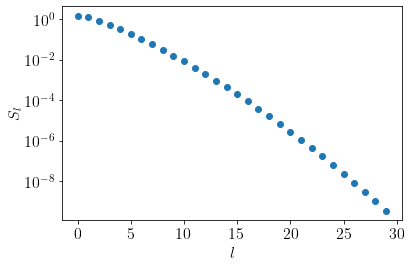

In [5]:
plt.semilogy(basis.s, marker='o', ls='')
plt.xlabel(r'$l$')
plt.ylabel(r'$S_l$')
plt.tight_layout()
plt.savefig('ir_basis_svals.pdf', transparent=True)

## $U_l(\tau)$ and $V_l(\omega)$

In [6]:
basis.u(np.array([0, 0.5*beta, beta]))

array([[ 1.12756986e+00,  1.59488091e-01,  1.12756986e+00],
       [-1.55855086e+00,  9.21156776e-19,  1.55855086e+00],
       [ 1.72691406e+00, -2.44209277e-01,  1.72691406e+00],
       [-1.88082340e+00, -1.84231355e-18,  1.88082340e+00],
       [ 1.88921360e+00,  2.67002917e-01,  1.88921360e+00],
       [-1.93558827e+00,  3.68462710e-18,  1.93558827e+00],
       [ 1.96432680e+00, -2.77301091e-01,  1.96432680e+00],
       [-2.00124241e+00,  0.00000000e+00,  2.00124241e+00],
       [ 2.03647135e+00,  2.86961406e-01,  2.03647135e+00],
       [-2.07219497e+00, -7.36925421e-18,  2.07219497e+00],
       [ 2.10714740e+00, -2.96143856e-01,  2.10714740e+00],
       [-2.14147567e+00,  0.00000000e+00,  2.14147567e+00],
       [ 2.17510637e+00,  3.04622473e-01,  2.17510637e+00],
       [-2.20810966e+00,  0.00000000e+00,  2.20810966e+00],
       [ 2.24054777e+00, -3.12379703e-01,  2.24054777e+00],
       [-2.27249083e+00, -1.47385084e-17,  2.27249083e+00],
       [ 2.30400318e+00,  3.19450356e-01

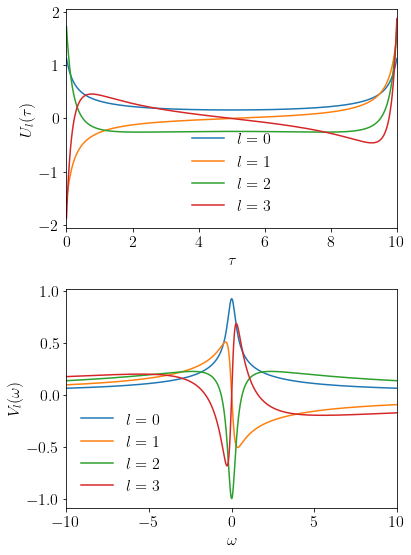

In [7]:
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axes = [ax1, ax2]

taus = np.linspace(0, beta, 1000)
omegas = np.linspace(-wmax, wmax, 1000)

for l in range(4):
    ax1.plot(taus, basis.u[l](taus), label=f'$l={l}$')
    ax2.plot(omegas, basis.v[l](omegas), label=f'$l={l}$')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$U_l(\tau)$')
ax2.set_ylabel(r'$V_l(\omega)$')
ax1.set_xlim([0,beta])
ax2.set_xlim([-wmax, wmax])

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('ir_basis_functions.pdf', transparent=True)

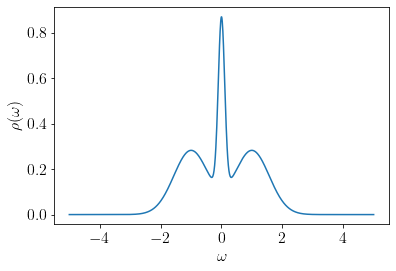

In [8]:
# Three Gaussian peaks (normalized to 1)
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

In [9]:
# Set up Composite Gauss-Legendre quadrature
# Let -wmax = w_1 < w_2 < ... < w_{N-1} < w_N = wmax be a partition of [-wmax, wmax],
# where w_2, ..., w_{N-1} are the roots of the highest basis function in omega.
# We apply Gauss-Legendre quadrature to each integral. 
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmax, xmin):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

# Roots of highest V_l
roots = basis.v[-1].roots()
bins = np.hstack((-wmax, roots, wmax))

x, w = leggauss(deg=20)
omegas_quad = []
weights_quad = []
for i in range(bins.size-1):
    x_, w_ = scale_quad(x, w, bins[i+1], bins[i])
    omegas_quad.append(x_)
    weights_quad.append(w_)
omegas_quad = np.hstack(omegas_quad)
weights_quad = np.hstack(weights_quad)

In [10]:
# Check orthogonality condition
for i in range(basis.size):
    for j in range(i, basis.size):
        print(i, j, weights_quad @ (basis.v[j](omegas_quad) * basis.v[i](omegas_quad)))

0 0 0.9999999999999997
0 1 -2.519414798313191e-17
0 2 3.455047391850291e-17
0 3 1.0460856898590609e-17
0 4 1.7879171450643772e-17
0 5 -5.736107118806122e-18
0 6 -1.2580133332620869e-17
0 7 1.0299920638612292e-17
0 8 3.22041926546085e-17
0 9 -2.3130775723620434e-17
0 10 1.560573502021323e-17
0 11 1.536178953140399e-17
0 12 -2.9063394486189553e-17
0 13 -8.605854744103691e-18
0 14 -6.233484865433847e-17
0 15 1.6195269951502222e-18
0 16 -7.209944447028604e-18
0 17 2.168404344971009e-19
0 18 -8.47371760433202e-17
0 19 -6.640738306473715e-19
0 20 -3.71881345162528e-17
0 21 6.478107980600889e-18
0 22 -1.2805782909769414e-16
0 23 4.560425388017153e-18
0 24 -9.272639080182277e-17
0 25 6.1663998560113065e-18
0 26 -4.8490942164414186e-17
0 27 -1.0679391398982219e-17
0 28 -1.3255726811350899e-16
0 29 -1.0354130747236567e-17
1 1 0.9999999999999997
1 2 -5.170289110040249e-18
1 3 -3.1228410699371545e-17
1 4 2.2836008257975937e-18
1 5 5.349860094858161e-18
1 6 5.04831636563563e-18
1 7 -1.2359904766334